# Simpsons Characters Recognition
## Definition and training of the neuronal network
I will implement a resnet 34. For the sake of learning I will not use a pretrained but follow the implementation shown by Aurélien Géron in chapter 14 of his book _"Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow"_ (https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)<br>
Notebooks consist of the following:
- Loading settings
- Splitting list of images into train, test and validation images
- Definition of the model
- Training the model
- Evaluation of the model with the testset

In [1]:
#Import libaries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

#Scikit-Learn und Models
from sklearn.model_selection import train_test_split

#Keras
import tensorflow as tf
from tensorflow import keras

#import custom functions
import simpsons_utils as su
import resnet34

### Settings and loading settings

In [2]:
#Settings
path = './'
train_path = './simpsons_dataset/'
test_path = './simpsons_testset/'

#chunk_size used so not all data needs to be read at once 
chunk_size = 128

#Load dict with settings for image correction
with open('./settings_dict.json',) as file:
    settings_dict = json.load(file)

#Load list of characters
with open('./char_list_reduced.json',)  as file:
    character_list = json.load(file)

### Splitting the image list
I split the list of training images further into chunks. So not all images need to be loaded into memory at the same time

In [3]:
#Read path and names to all image files
image_files, labels = su.create_train_image_list(train_path, character_list)

#Split data into train and test, split train into train and validate 
X_train, X_test, y_train, y_test = train_test_split(image_files,
                                          labels,
                                          train_size=0.8,
                                          stratify=labels)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  train_size=0.8,
                                                  stratify=y_train)

In [4]:
#Length of all datasets
print(f"Images in Trainset:\t{X_train.shape}\nImages in Validationset:{X_val.shape}\nImages in Testset\t{X_test.shape}")

Images in Trainset:	(12510,)
Images in Validationset:(3128,)
Images in Testset	(3910,)


In [5]:
#split image list of train images into chunks
X_train_chunks, y_train_chunks = su.make_chunks(X_train, y_train, chunk_size)

### Model Definiton
- Declare a residual layer class which will be by the model
- Declare function for model definition
- Create model

In [6]:
model = resnet34.resnet34(settings_dict)

#compile model, needed before usage
model.compile(loss='sparse_categorical_crossentropy'
              , optimizer=keras.optimizers.Adam()
              , metrics=['accuracy'])

#print summary of model and save model defintion to file
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 24, 24, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 24, 24, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 24, 24, 64)        7

### Training of the model
- Load old weights if available

In [8]:
#Load model if exists
try:
    model.load_weights(f'{path}/simpsons_keras_model.h5')
except:
    print('Weights file does not exist')

In [14]:
#Train Model
#model will be trained in several chunks of data rather than in one go

#callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("simpsons_keras_model.h5", save_best_only=True)

#Train Model. Load only batches of the train and validate data. Train same data on multiple validate data
no_chunks = len(X_train_chunks)

X_val_images = su.load_transform_images(X_val, settings_dict)
#Load batches of images an train
for idn, (X_train_chunk, y_train_chunk) in enumerate(zip(X_train_chunks, y_train_chunks)):
    print(f"Chunk: {idn + 1}/{no_chunks}")
    X_train_images = su.load_transform_images(X_train_chunk, settings_dict)
    #train
    history = model.fit(X_train_images, y_train_chunk, epochs=100
                        , validation_data=(X_val_images, y_val)
                        , callbacks=[early_stopping_cb]
                        , workers = 7
                        , use_multiprocessing=True
                           )
    #save model weights
    model.save_weights(f'{path}/simpsons_keras_model.h5')

Chunk: 1/98
4/4 [==============================] - 26s 6s/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 3.3959 - val_accuracy: 0.6218
Chunk: 2/98
4/4 [==============================] - ETA: 0s - loss: 2.4730 - accuracy: 0.7969

KeyboardInterrupt: 

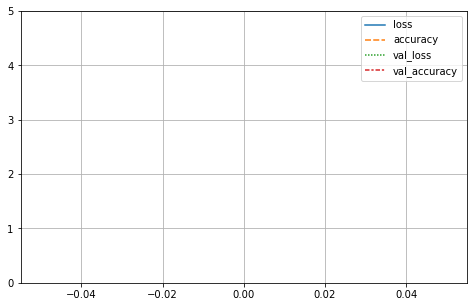

In [15]:
#Plot history of training
df_hist = history.history
plt.figure(figsize=(8, 5))
plt.grid(True)
acc_plot = sns.lineplot(data=df_hist)
acc_plot.set_ylim(0, 5);

### Evalutation on Testset

In [ ]:
#Evaluate on Testset
X_test_images = su.load_transform_images(X_test, settings_dict)
model.evaluate(X_test_images, y_test)